# Libraries

In [1]:
import collections
import copy
import itertools
import json
import logging
# Imports and setup
import os
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj, k_hop_subgraph
from tqdm.notebook import tqdm

In [2]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Suppress PDB warnings globally
warnings.simplefilter('ignore', PDBConstructionWarning)

from preprocessing_v3 import ProteinAnalyzer, process_pdb_directory
from utils_ln import load_aa_info  # Or define `load_aa_info` in the same script

# Configuration

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
sns.set_theme()

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

def compute_average_edges(data_loader):
    """
    Compute the average number of edges and nodes in the dataset
    """
    total_edges = 0
    total_nodes = 0
    num_graphs = 0

    for batch in data_loader:
        total_edges += batch.edge_index.size(1) // 2  # Divide by 2 for undirected edges
        total_nodes += batch.x.size(0)
        num_graphs += 1

    return {
        'avg_edges': total_edges / num_graphs,
        'avg_nodes': total_nodes / num_graphs,
        'avg_backbone': total_nodes / num_graphs - 1  # One less than nodes
    }

# Paths and constants

In [4]:
# Define the file for a demo protein structure
pdb_file = 'data/all_nano_structures_single_domain/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = 'data/mab_dataset/selection'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

# Preprocessed protein dataframes 
output_dir = "processed_dataframes"

# Preprocessing

In [15]:
# Load amino acid information
aa_info = pd.read_csv(aa_info_file)
aa_info['Abbrev.'] = aa_info['Abbrev.'].apply(lambda x: x.upper())
aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')
#aa_info_dict

In [20]:
# Process PDB directory
dataframes = process_pdb_directory(pdb_directory, aa_info_dict, neighborhood_radius=5.0)


Processing PDBs: 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]


In [21]:
dataframes[3]

('data/mab_dataset/selection/5vm0.pdb',
              X          Y          Z   Avg_Mass  Avg_Neighbor_Dist  \
 0     8.860000   9.534000 -24.737000   89.09404           3.791493   
 1     9.455000  10.370000 -21.087000  147.13074           3.803399   
 2     5.820000   9.280000 -20.693001  117.14784           4.039696   
 3     3.352000   7.024000 -22.552000  146.14594           3.835302   
 4    -0.477000   7.372000 -22.573999  131.17464           4.195998   
 ..         ...        ...        ...        ...                ...   
 247 -35.091999  29.827000  -3.722000  117.14784           4.277517   
 248 -38.639999  30.881001  -4.502000  105.09344           4.156789   
 249 -41.056000  29.899000  -7.276000  105.09344           3.793249   
 250 -40.549999  32.519001  -9.952000  115.13194           3.784674   
 251 -42.397999  35.735001  -9.172000   75.06714           3.790271   
 
      Max_Neighbor_Dist  Neighbor_Count  Small_Molecules_Found  
 0             3.791493               1  

In [8]:
import os

# Directory to store processed DataFrames
os.makedirs(output_dir, exist_ok=True)

# Save each DataFrame to a pickle file
for pdb_file, df in dataframes:
    pdb_id = os.path.basename(pdb_file).replace('.pdb', '')  # Extract PDB ID from filename
    df.to_pickle(os.path.join(output_dir, f"{pdb_id}.pkl"))

print(f"DataFrames saved in {output_dir} as pickle files")


DataFrames saved in processed_dataframes as pickle files


# Graph conversion

In [30]:
def dataframe_to_graph(df, neighborhood_radius=5.0, include_coordinates=True, include_small_molecules=True):
    """Convert a DataFrame into a graph for GNN."""
    # Base node features
    features_to_include = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count']
    if include_small_molecules:
        features_to_include.append('Small_Molecules_Found')

    node_features = df[features_to_include].values

    # Optionally include coordinates as part of the node features
    if include_coordinates:
        coords = df[['X', 'Y', 'Z']].values
        node_features = np.hstack([node_features, coords])  # Combine features and coordinates

    node_features = torch.tensor(node_features, dtype=torch.float)

    # Build edges based on neighborhood radius
    coords = df[['X', 'Y', 'Z']].values  # Use coordinates for distance computation
    edge_index = []
    edge_attr = []

    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist <= neighborhood_radius:
                # Add bidirectional edges
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist])  # Use distance as edge feature
                edge_attr.append([dist])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # Shape: [2, num_edges]
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)  # Shape: [num_edges, edge_features]

    # Graph data object
    data = Data(
        x=node_features,      # Node features
        edge_index=edge_index,  # Edges
        edge_attr=edge_attr,   # Edge features (distances)
    )

    return data


In [31]:
# graphs = []  # Define `graphs` outside the loop
for pdb_file, df in tqdm(dataframes, desc="Processing", unit="graph", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
    graph = dataframe_to_graph(df, neighborhood_radius=5.0, include_coordinates=True, include_small_molecules=True)
    graphs.append((pdb_file, graph))


Processing:   0%|          | 0/71 [00:00<?]

In [32]:
graphs[2]

('data/all_nano_structures_single_domain_clean/selection_1/8e1b.pdb',
 Data(x=[115, 8], edge_index=[2, 294], edge_attr=[294, 1]))

In [33]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

# Extract the PyTorch Geometric Data object from your graphs list
pdb_file, data = graphs[2]

# Convert to NetworkX for visualization
G = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'])


/home/lara/Documents/CAS_AML/Projects/M3/m3_venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


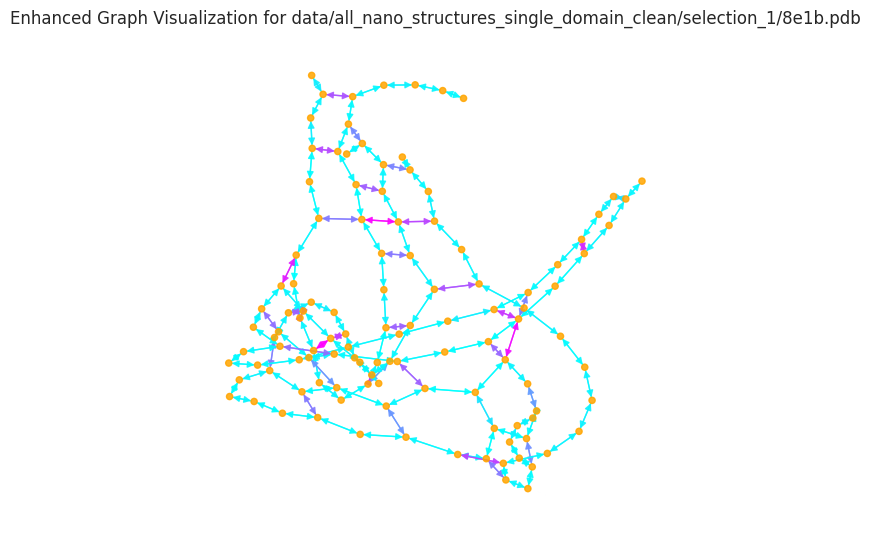

In [40]:
def visualize_graph(G, pdb_file, highlight_nodes=None):
    """Enhanced visualization with improved colors and visibility."""
    plt.figure(figsize=(5, 5))
    
    # Use spring layout for better distribution
    pos = nx.spring_layout(G, seed=42)
    
    # Extract attributes for visualization
    node_sizes = [max(20, node[1]['x'][0] * 50) for node in G.nodes(data=True)]  # Scale and set a minimum size
    edge_weights = [max(0.5, edge[2]['edge_attr'][0] * 2) for edge in G.edges(data=True)]  # Scale and set a minimum width
    
    # Highlight specific nodes if provided
    if highlight_nodes:
        node_colors = [
            'red' if node in highlight_nodes else 'orange' for node in G.nodes
        ]
    else:
        node_colors = 'orange'
    
    # Draw the graph with enhanced visibility
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_size=node_sizes,
        edge_color=edge_weights,
        edge_cmap=plt.cm.cool,  # Use a more visible colormap
        node_color=node_colors,
        cmap=plt.cm.plasma,  # Distinguishable node colors
        alpha=0.85  # Set opacity for better visibility
    )
    
    # Add a title
    plt.title(f"Enhanced Graph Visualization for {pdb_file}")
    plt.show()

# Use the function
visualize_graph(G, pdb_file)


Pymol visualization of the same protein: 

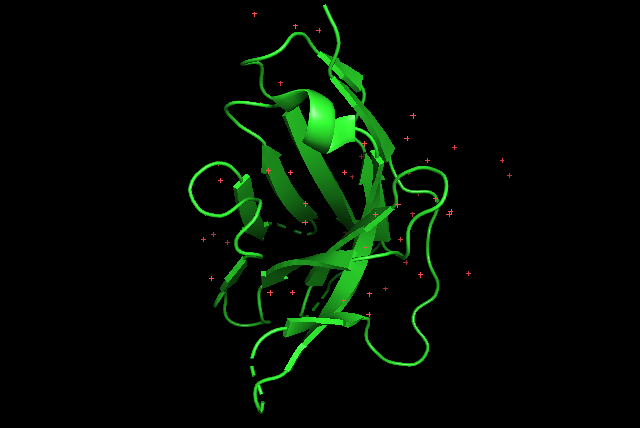

In [41]:
from IPython.display import Image, display

# Path to your PNG file
image_path = "data/8e1b_pymol_file.png"  # Replace with the actual path to your saved PNG

# Display the image
display(Image(filename=image_path))


DO the representation makes sense?

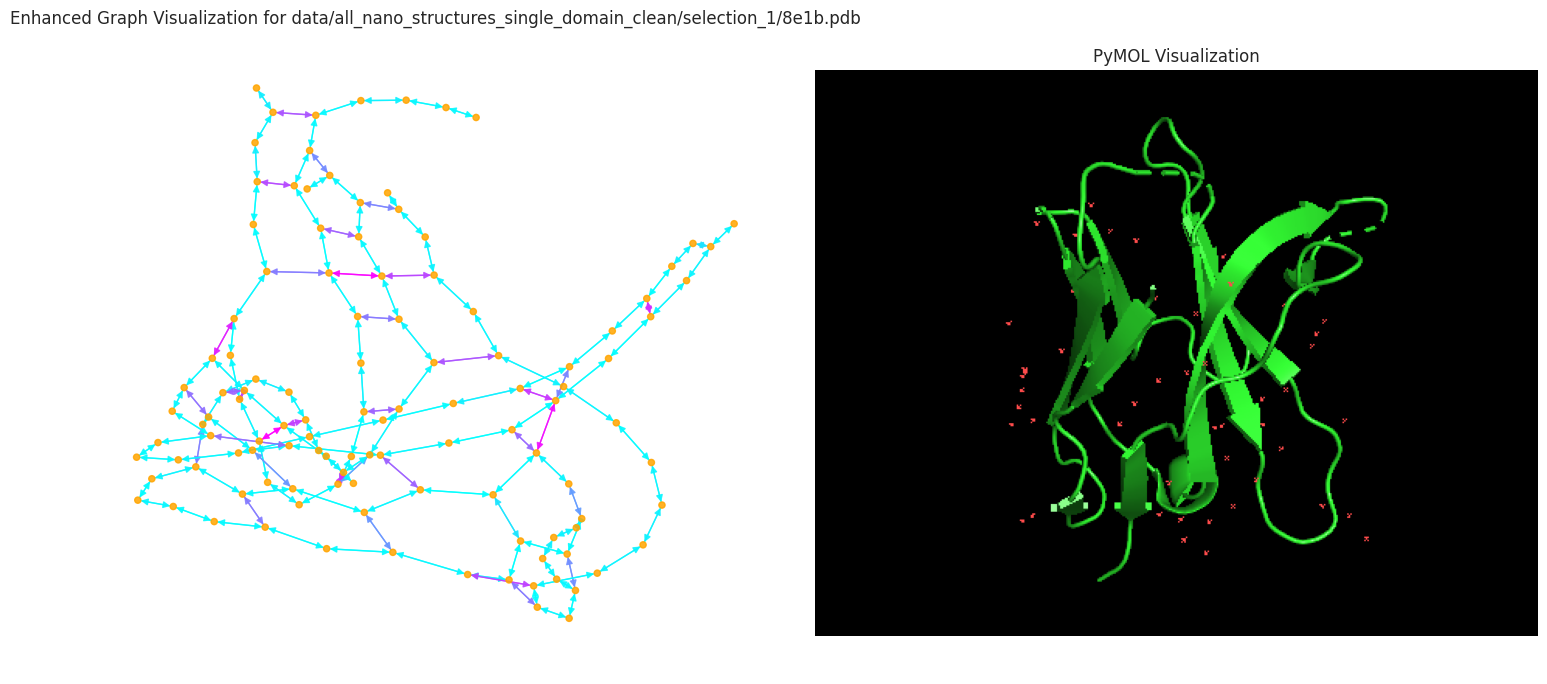

In [43]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph_and_pymol(G, pdb_file, pymol_image_path, highlight_nodes=None):
    """Visualize the graph and PyMOL image side by side."""
    # Set up a side-by-side figure layout
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Visualization 1: Graph
    ax1 = axes[0]
    plt.sca(ax1)  # Set current axis to the first subplot
    
    # Use spring layout for better distribution
    pos = nx.spring_layout(G, seed=42)
    
    # Extract attributes for visualization
    node_sizes = [max(20, node[1]['x'][0] * 50) for node in G.nodes(data=True)]  # Scale and set a minimum size
    edge_weights = [max(0.5, edge[2]['edge_attr'][0] * 2) for edge in G.edges(data=True)]  # Scale and set a minimum width
    
    # Highlight specific nodes if provided
    if highlight_nodes:
        node_colors = [
            'red' if node in highlight_nodes else 'orange' for node in G.nodes
        ]
    else:
        node_colors = 'orange'
    
    # Draw the graph with enhanced visibility
    nx.draw(
        G,
        pos,
        ax=ax1,  # Plot on the current axis
        with_labels=False,
        node_size=node_sizes,
        edge_color=edge_weights,
        edge_cmap=plt.cm.cool,  # Use a more visible colormap
        node_color=node_colors,
        cmap=plt.cm.plasma,  # Distinguishable node colors
        alpha=0.85  # Set opacity for better visibility
    )
    ax1.set_title(f"Enhanced Graph Visualization for {pdb_file}")
    
    # Visualization 2: PyMOL Image
    ax2 = axes[1]
    ax2.axis('off')  # Turn off the axis for the image
    img = plt.imread(pymol_image_path)  # Read the PyMOL PNG image
    ax2.imshow(img)  # Display the image
    ax2.set_title("PyMOL Visualization")
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage
visualize_graph_and_pymol(
    G, 
    pdb_file="data/all_nano_structures_single_domain_clean/selection_1/8e1b.pdb", 
    pymol_image_path="data/8e1b_pymol_file_rot.png"
)


Save the graph informations for overlay in pymol and verification of a meaningful graph creation: 

In [39]:
import pandas as pd

# Assuming `graph` is a single PyTorch Geometric Data object
def extract_graph_info(graph, feature_names):
    # Extract coordinates (last 3 columns if include_coordinates=True)
    coords = graph.x[:, -3:].numpy()  # Extract X, Y, Z coordinates
    
    # Extract node features
    features = graph.x[:, :-3].numpy()  # Remaining features (excluding coordinates)

    # Combine coordinates and features into a DataFrame
    data = pd.DataFrame(coords, columns=['X', 'Y', 'Z'])
    for i, feature_name in enumerate(feature_names[:-3]):  # Skip coordinate labels
        data[feature_name] = features[:, i]
    
    return data

# Example usage:
feature_names = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count', 'Small_Molecules_Found', 'X', 'Y', 'Z']
graph_info_df = extract_graph_info(graph, feature_names)

# Save the DataFrame to a CSV for manual inspection or overlay
graph_info_df.to_csv("graph_info.csv", index=False)


# Dataloader

In [46]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

def split_and_batch_graphs(graphs, batch_size=16, train_ratio=0.8, seed=42):
    """
    Split the graphs into train and test datasets, and create DataLoaders for batching.

    Parameters:
    - graphs (list): List of `torch_geometric.data.Data` graphs.
    - batch_size (int): Batch size for the DataLoader.
    - train_ratio (float): Proportion of data to use for training.
    - seed (int): Random seed for reproducibility.

    Returns:
    - train_loader (DataLoader): DataLoader for the training set.
    - test_loader (DataLoader): DataLoader for the testing set.
    """
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    
    # Split into train and test sets
    train_graphs, test_graphs = train_test_split(graphs, train_size=train_ratio, random_state=seed)
    
    # Create DataLoaders
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


In [47]:
# Example Usage
# If `graphs` already contains only `Data` objects, no need to unpack
train_loader, test_loader = split_and_batch_graphs(graphs, batch_size=16, train_ratio=0.8)

# Check the loaders
for batch in train_loader:
    print(batch)
    break


DataBatch(x=[20562, 8], edge_index=[2, 50880], edge_attr=[50880, 1], batch=[20562], ptr=[17])


Here's a breakdown of the components:

x=[20562, 8]: There are 20,562 nodes, each with 8 features (including optional 3D coordinates, average distances, etc., from your Data creation process).
edge_index=[2, 50880]: There are 50,880 edges in the batch, represented as a 2-row tensor where each column corresponds to an edge (source node, target node).
edge_attr=[50880, 1]: Each edge has 1 feature (likely the distance, as per your graph creation process).
batch=[20562]: This tensor indicates which graph each node belongs to, mapping each node to its graph in the batch.
ptr=[17]: This tensor provides pointers to the start indices of graphs in the batch. If you have 17 graphs in the batch, it means they have been concatenated into this single batch.
Interpretation:
This is a batched representation of your graphs, ready to be fed into a GNN model. Each component of the DataBatch provides the necessary information for processing multiple graphs simultaneously.

## Does this makes sense?

In typical machine learning scenarios like image processing, a "batch" contains a specific number of examples (e.g., 16 images in one batch). For your graph dataset, the batch contains multiple graphs, but they are combined into a single structure for efficient processing.

Here’s why it looks like "everything is together":

PyTorch Geometric combines all the nodes, edges, and features of the graphs in a batch into a single data structure.
The batch tensor within the DataBatch object is the key to separating the graphs. It tells the model which nodes and edges belong to which graph.
Let’s clarify this:

Example
If you batch 3 small graphs:

Graph 1: 4 nodes, 5 edges.
Graph 2: 3 nodes, 4 edges.
Graph 3: 5 nodes, 6 edges.
The batched result looks like this:

Nodes (x): Combined node features for all graphs, shape [12, features] (4+3+5 = 12 nodes).
Edges (edge_index): Combined edges, shape [2, 15] (5+4+6 = 15 edges).
Batch (batch): Tensor of size 12, assigning nodes to graphs, e.g., [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2].
Separation within a Batch
The batch tensor allows you to:

Identify which nodes belong to which graph.
Identify which edges are part of each graph.
The ptr tensor in the DataBatch object provides pointers to separate the graphs during training.

In [48]:
print(batch.ptr)  # Shows the start indices of each graph
num_graphs = len(batch.ptr) - 1
print(f"Number of graphs in the batch: {num_graphs}")

tensor([    0,   441,  4118,  5390,  5505,  5834,  6108,  7114,  9628, 11227,
        11778, 12517, 14023, 14984, 16124, 17084, 20562])
Number of graphs in the batch: 16
